# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## 1. Откройте и изучите файл

В проекте для анализа представлена таблица, в которой содержатся объемы услуг, использованных каждым клиентом оператора сотовой связи. При помощи этих данных на основе алгоритмов машинного обучения предстоит решить задачу классификации, а именно рекомендации каждому клиенту одного из двух тарифов. Для начала необходимо изучить представленные данные. Так как предобработка проведена без нашего участия, этот этап не займет много времени. Далее необходимо разбить датасет на три выборки (обучающую, валидационную и тестовую), ведь отдельных данных для тестирования модели у нас нет. Разделим их в соотношении 3:1:1. На следующем этапе неоходимо обучить модели (дерево решений, случайный лес и логистическая регрессия) и проверить их метрику качества при различных гиперпараметрах. Для лучшей модели произведем расчет метрики качества уже на тестовой выборке и при необходимости улучшим показатели выше значения 0.75.  

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [2]:
tariffs = pd.read_csv('/datasets/users_behavior.csv')
tariffs.info()
display(tariffs.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


В таблице представлены данные о количестве звонков, потраченных на них минутах, сообщениях, использованном объеме
интернет-трафика (в Mb). Также есть информация о тарифе, использует ли клиент тариф "Ultra". Последнее поле используем в качестве целевого признака, остальные применим в качестве признаков.  

## 2. Разбейте данные на выборки

In [4]:
tariffs_features = tariffs.drop("is_ultra", axis = 1) 
tariffs_target =  tariffs ["is_ultra"]
features_train, features_valid_test, target_train, target_valid_test = train_test_split(tariffs_features,
                                                                                        tariffs_target, test_size = 0.4, random_state = 500)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test,
                                                                                        target_valid_test, test_size = 0.5, random_state = 500)
print('----------------features_test--------------------')
features_test.info()
display(features_test.head())

print('----------------target_test--------------------')
print("Размер выборки:",target_test.shape[0])
display(target_test.head())

print('----------------features_valid--------------------')
features_valid.info()
display(features_valid.head())

print('----------------features_train--------------------')
features_train.info()
display(features_train.head())

print('----------------target_valid--------------------')
print("Размер выборки:",target_valid.shape[0])
display(target_valid.head())

print('----------------target_train--------------------')
print("Размер выборки:",target_train.shape[0])
display(target_train.head())

print('Соотношение:')
print('--> тренировка', round(features_train.shape[0] / tariffs.shape[0], 2))
print('--> валидация', round(features_valid.shape[0] / tariffs.shape[0], 2))
print('--> тест', round(features_test.shape[0] / tariffs.shape[0], 2))


----------------features_test--------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 643 entries, 3077 to 882
Data columns (total 4 columns):
calls       643 non-null float64
minutes     643 non-null float64
messages    643 non-null float64
mb_used     643 non-null float64
dtypes: float64(4)
memory usage: 25.1 KB


,calls,minutes,messages,mb_used
3077,22.0,120.09,16.0,9039.57
3037,64.0,468.21,16.0,14669.87
1045,84.0,597.27,3.0,33352.80
2252,133.0,949.36,0.0,19036.43
1630,80.0,543.50,3.0,16831.90


----------------target_test--------------------
Размер выборки: 643


3077    0
3037    0
1045    1
2252    1
1630    0
Name: is_ultra, dtype: int64

----------------features_valid--------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 643 entries, 2798 to 1151
Data columns (total 4 columns):
calls       643 non-null float64
minutes     643 non-null float64
messages    643 non-null float64
mb_used     643 non-null float64
dtypes: float64(4)
memory usage: 25.1 KB


,calls,minutes,messages,mb_used
2798,71.0,485.12,46.0,16702.03
1635,68.0,464.62,6.0,5810.80
340,52.0,305.64,67.0,15329.36
2096,81.0,567.34,11.0,14121.36
1992,21.0,129.45,162.0,18021.07


----------------features_train--------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1928 entries, 2185 to 2906
Data columns (total 4 columns):
calls       1928 non-null float64
minutes     1928 non-null float64
messages    1928 non-null float64
mb_used     1928 non-null float64
dtypes: float64(4)
memory usage: 75.3 KB


,calls,minutes,messages,mb_used
2185,56.0,355.13,30.0,9192.92
1852,74.0,563.59,30.0,10781.76
1703,78.0,483.81,21.0,23076.65
2730,74.0,549.14,20.0,17160.61
1716,57.0,417.39,39.0,10604.94


----------------target_valid--------------------
Размер выборки: 643


2798    0
1635    0
340     0
2096    1
1992    1
Name: is_ultra, dtype: int64

----------------target_train--------------------
Размер выборки: 1928


2185    0
1852    0
1703    0
2730    0
1716    0
Name: is_ultra, dtype: int64

Соотношение:
--> тренировка 0.6
--> валидация 0.2
--> тест 0.2


Для разбиения датасета на тестовую, валидационную и обучающую выборки воспользуемся методом train_test_split, причем дважды. Объемы выборок соответствуют стандартоному соотношению 3:1:1. Перед началом разбиения выделим в отдельные переменные целевой признак и остальные признаки. 

In [5]:
# КОД РЕВЬЮВЕРА

print('Соотношение:')
print('--> тренировка', round(features_train.shape[0] / tariffs.shape[0], 2))
print('--> валидация', round(features_valid.shape[0] / tariffs.shape[0], 2))
print('--> тест', round(features_test.shape[0] / tariffs.shape[0], 2))

Соотношение:
--> тренировка 0.6
--> валидация 0.2
--> тест 0.2


## 3. Исследуйте модели

In [6]:
depth_tree = 0
accuracy_tree = 0
#def decision_tree(features, target):
for depth in range(1,20):
    model_1 = DecisionTreeClassifier(random_state = 12345, max_depth = depth)
    model_1.fit(features_train, target_train)
    prediction = model_1.predict(features_valid)
    accuracy_1 = accuracy_score(target_valid, prediction)
    if accuracy_1 > accuracy_tree:
        depth_tree = depth
        accuracy_tree = accuracy_1 
print("Для дерева решений наилучшее значение accuracy", accuracy_tree,'достигается при значении max_depth =', depth_tree)
print("---------------------------------------------")
count_trees = 0
accuracy_forest = 0
for i in range(1,12):
    for c in range(1,12):
        model_2 = RandomForestClassifier(random_state = 12345, n_estimators = i, max_depth = c)
        model_2.fit(features_train, target_train)
        accuracy_2 = model_2.score(features_valid, target_valid)
        if accuracy_2 > accuracy_forest:
            accuracy_forest = accuracy_2
            count_trees = i
            depth_forest_tree = c
print("Для случайного леса наилучшее значение accuracy", accuracy_forest,'достигается при значении n_estimators =', count_trees, 
     'и max_depth =', depth_forest_tree)
print("---------------------------------------------")
model_3 = LogisticRegression(random_state = 12345, solver = 'liblinear')
model_3.fit(features_train, target_train)
accuracy_logistic = model_3.score(features_valid, target_valid)
print("Для логистической регрессии наилучшее значение accuracy", accuracy_logistic)
print("---------------------------------------------")
if accuracy_tree > accuracy_forest:
    model_best = model_1
    best_accuracy = accuracy_tree
    print("В итоге лучшая модель на основе алгоритма дерева решений")
else:
    model_best = model_2
    best_accuracy = accuracy_forest
    print("В итоге лучшая модель на основе алгоритма случайного леса")
if accuracy_logistic > best_accuracy:
    model_best = model_3
    print("В итоге лучшая модель на основе алгоритма логистической регрессии")

Для дерева решений наилучшее значение accuracy 0.7822706065318819 достигается при значении max_depth = 5
---------------------------------------------
Для случайного леса наилучшее значение accuracy 0.7962674961119751 достигается при значении n_estimators = 8 и max_depth = 11
---------------------------------------------
Для логистической регрессии наилучшее значение accuracy 0.7045101088646968
---------------------------------------------
В итоге лучшая модель на основе алгоритма случайного леса


После изменения гиперпараметров (для дерева решений - максимальная глубина, для случайного леса - количестов оценщиков, для логистической регресии выбран 1 постоянный параметр 'solver' в целях избежания некритичных ошибок кода) определили наилучшие параметры для каждой модели обученной на тренировочной выборке. После перезагрузки кода программы значения метрик изменяются. Наибольшие результаты наблюдаются у моделей дерева решений и случайного леса, однако модель дерева решений чаще показывает максимальное значение accuracy.  

## 4. Проверьте модель на тестовой выборке

In [7]:
#model_best.fit(features_train, target_train)
print("Значение метрики для валидационной выборки", model_best.score(features_valid, target_valid))
if model_best.score(features_test, target_test) >= 0.75:
    print("Значение метрики для тестовой выборки", model_best.score(features_test, target_test),
          "лучше порогового значения, просто огонь!!!")
else:
    print("Значение метрики для тестовой выборки", model_best.score(features_test, target_test),
          ", результат не дотягивает( надо оптимизировать модель")
print(model_1.score(features_test, target_test))
print(model_2.score(features_test, target_test))
print(model_3.score(features_test, target_test))

Значение метрики для валидационной выборки 0.7962674961119751
Значение метрики для тестовой выборки 0.7993779160186625 лучше порогового значения, просто огонь!!!
0.7340590979782271
0.7993779160186625
0.7216174183514774


В целях оценки лучшей модели применим метод score() для тестовой выборки и в зависимости от его значения выведем соответствующее сообщение. При любом из выдавемых значений accuracy > 0.75. Также для сравнения выведем параметр accuracy при работе с валидационной выборкой.

## 5. (бонус) Проверьте модели на адекватность

In [8]:
print(roc_auc_score(target_test, model_best.predict(features_test)),'> 0.5, адекватности нашей модели не занимать.')

0.7216393633089346 > 0.5, адекватности нашей модели не занимать.


AUC forest_rev test 0.7957360288137562


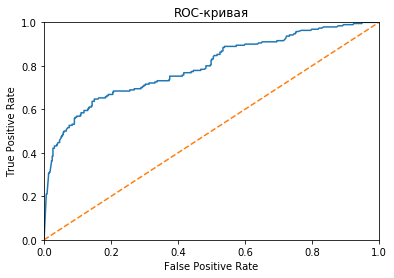

Гиперпараметры best_model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=11, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=11,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)


In [10]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# сформируем предсказания на тесте (именно вероятность принадлежности к классу)
prob = model_best.predict_proba(features_test)[:, 1]

print('AUC forest_rev test', roc_auc_score(target_test, prob))

fpr, tpr, thresholds = roc_curve(target_test, prob)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print('Гиперпараметры best_model', model_best)

В рассмотренном проекте происходила работа с данными сотового оператора. Для начала пришлось разобрать исходный датасет на выборки в соотношении 3:1:1 (обучающая, тестовая, валидационная) и проверить, действительно ли выборки получились такими по размеру. Далее для решения поставленной задачи осуществлялся выбор наилучшей модели в соответствии с применяемыми алгоритмати и гиперпараметрами. В итоге лучший результат показала модель случайного леса. Для тестовой выборки данная модель также оказалась наилучшей по показателю accuracy (0.8164852255054432), что лучше, чем пороговое значение 0.75. Также проведен тест на адекватность модели с помощью метода оценки значения AUC. В итоге данная вероятность оказалась выше, чем 0.5, соответственно модель для классификации тарифа применять эффективнее, нежели определять случайным равновероятным образом.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 4: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
